# LSTM Model for Stock Price Forecasting

This notebook uses an LSTM (Long Short-Term Memory) model to predict the next-day closing price of GOOGL stock using past 5 days of historical data.

## Step 1: Data Collection and Preprocessing

### 1.1 Import Libraries

In [1]:
import os
import random
import numpy as np

# 1) Set seeds and deterministic ops BEFORE importing TensorFlow
os.environ["PYTHONHASHSEED"] = "42"       # hash seed
os.environ["TF_DETERMINISTIC_OPS"] = "1"  # prefer deterministic TF kernels if available
# Optional on some CUDA stacks:
# os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"  # or ":4096:8"

random.seed(42)
np.random.seed(42)

import tensorflow as tf
try:
    # TF 2.9+; makes many GPU ops deterministic
    tf.config.experimental.enable_op_determinism(True)
except Exception:
    pass

tf.random.set_seed(42)

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras import layers, models, callbacks, backend as K


/Users/arvindshine/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### 1.2 Download and Prepare GOOGL Stock Data

This block downloads daily OHLCV (Open, High, Low, Close, Volume) data for GOOGL from Yahoo Finance between 2010-01-01 and 2021-05-31. The dataset is reformatted to include standard columns and sorted by date, ensuring consistency before further preprocessing.

In [2]:
df = yf.download(
    "GOOGL",
    start="2010-01-01",
    end="2021-05-31",
    group_by="column",     # avoid MultiIndex
    auto_adjust=False,     # keep Close/Adj Close separate; we model split-adjusted Close (same "Close")
    progress=False,
).reset_index()

# Normalize schema
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)
df = df[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]

print(df.head(2)); print(df.tail(2))
print("Date span:", df["Date"].min().date(), "→", df["Date"].max().date(), "| rows:", len(df))


Price        Date       Open       High        Low      Close  Adj Close  \
Ticker                 GOOGL      GOOGL      GOOGL      GOOGL      GOOGL   
0      2010-01-04  15.689439  15.753504  15.621622  15.684434  15.590930   
1      2010-01-05  15.695195  15.711712  15.554054  15.615365  15.522272   

Price      Volume  
Ticker      GOOGL  
0        78169752  
1       120067812  
Price        Date        Open        High         Low       Close   Adj Close  \
Ticker                  GOOGL       GOOGL       GOOGL       GOOGL       GOOGL   
2869   2021-05-27  119.452499  119.452499  117.813004  118.134003  117.429749   
2870   2021-05-28  118.721001  118.803497  117.642502  117.842499  117.139969   

Price     Volume  
Ticker     GOOGL  
2869    35224000  
2870    21482000  
Date span: 2010-01-04 → 2021-05-28 | rows: 2871


### 1.3 Feature Engineering and Target Construction

In this stage, the raw Yahoo Finance data was refined into a consistent schema, ensuring that all core OHLCV fields were preserved. Additional predictors were then engineered to enrich the dataset. A log transformation was applied to trading volume to reduce skewness, and calendar-based features such as day-of-week and day-of-year were added to capture seasonality. Rolling indicators were computed, including a 20-day moving average to represent short-term trend and a 20-day rolling standard deviation to measure volatility. Momentum dynamics were incorporated through the 14-day Relative Strength Index (RSI). The prediction target was defined as the next-day closing price by shifting the Close series forward by one step. Any NaN values introduced through rolling calculations and target shifting were dropped to maintain data integrity. Finally, a compact but diverse feature set was defined—comprising price-based variables, calendar effects, moving averages, volatility, and RSI—and sequences of length 5 were constructed so that the model could learn from the most recent five days when predicting the next-day close.

In [3]:
# 2a) Ensure base schema + flatten MultiIndex if present
_base = ["Date","Open","High","Low","Close","Adj Close","Volume"]

# Handle cases where Yahoo Finance returns MultiIndex columns
if isinstance(df.columns, pd.MultiIndex):
    df = df.copy()
    df.columns = [c[0] if isinstance(c, tuple) else c for c in df.columns]

_missing = [c for c in _base if c not in df.columns]
assert not _missing, f"Missing base columns: {_missing}. Re-run Step 1."

# Work on a copy
df_feat = df.copy()


In [4]:
# 2b) Deterministic transforms (log volume + calendar features)
df_feat["log_volume"]  = np.log(df_feat["Volume"].astype(float) + 1e-8)
df_feat["day_of_week"] = pd.to_datetime(df_feat["Date"]).dt.weekday
df_feat["day_of_year"] = pd.to_datetime(df_feat["Date"]).dt.dayofyear

# 2c) Past-only rolling indicators (require history)
df_feat["MA_20"]         = df_feat["Close"].rolling(window=20, min_periods=20).mean()
df_feat["Volatility_20"] = df_feat["Close"].rolling(window=20, min_periods=20).std()

# 2d) RSI-14 (Wilder’s smoothing)
delta = df_feat["Close"].diff()
up    = delta.clip(lower=0)
down  = -delta.clip(upper=0)

roll_up   = up.ewm(alpha=1/14, adjust=False, min_periods=14).mean()
roll_down = down.ewm(alpha=1/14, adjust=False, min_periods=14).mean()

rs = roll_up / (roll_down + 1e-8)
df_feat["RSI_14"] = 100 - (100 / (1 + rs))


In [5]:
# 2e) One-step-ahead target (t+1 Close)
df_feat["Target"] = df_feat["Close"].shift(-1)


In [6]:
# 2f) Drop NaNs caused by rolling + shift
_need = ["MA_20","Volatility_20","RSI_14","Target"]

print("NaNs prior to drop:", df_feat[_need].isna().sum().to_dict())

df_model = df_feat.dropna(subset=_need).reset_index(drop=True)


NaNs prior to drop: {'MA_20': 19, 'Volatility_20': 19, 'RSI_14': 14, 'Target': 1}


In [7]:
# 2g) Define features and sequence length
FEATURES = [
    'Close','High','Low','log_volume',
    'day_of_week','day_of_year',
    'MA_20','Volatility_20','RSI_14'
]
SEQ_LEN  = 5

print("Rows after drops:", len(df_model))
print("Span:", df_model['Date'].iloc[0].date(), "→", df_model['Date'].iloc[-1].date())
print("Feature columns:", FEATURES)


Rows after drops: 2851
Span: 2010-02-01 → 2021-05-27
Feature columns: ['Close', 'High', 'Low', 'log_volume', 'day_of_week', 'day_of_year', 'MA_20', 'Volatility_20', 'RSI_14']


## Step 2: Exploratory Data Analysis

Suggested Text:
Since the same dataset and preprocessing framework were applied, I did not repeat the entire EDA process for the LSTM model. A detailed EDA was already conducted during the SVR phase, which included analyzing GOOGL stock price trends, 5-day moving averages with volatility, and calendar-based patterns (day-of-week, day-of-year). Feature correlations were also examined to identify the most relevant predictors. For the LSTM model, additional engineered features (20-day moving average, 20-day volatility, and RSI-14) were incorporated, but their behavior had already been visually and statistically assessed during the earlier EDA stage.

## Step 3 Train-Test Split:

The dataset was split chronologically into training and testing sets using an 80/20 ratio to preserve the temporal ordering of stock prices. The training set spans February 2010 to February 2019, while the testing set covers February 2019 to May 2021. This ensures that the model is evaluated on unseen future data, avoiding data leakage and maintaining the realistic forecasting setup.

In [8]:
# 3) Split rows chronologically (80/20) — no sequences yet
SEQ_LEN = 5
FEATURES = ['Close','High','Low','log_volume','day_of_week','day_of_year','MA_20','Volatility_20','RSI_14']

n_total = len(df_model)
n_train = int(0.8 * n_total)

df_train = df_model.iloc[:n_train].copy()
df_test  = df_model.iloc[n_train:].copy()

print(f"Train rows: {len(df_train)} | {df_train['Date'].iloc[0].date()} → {df_train['Date'].iloc[-1].date()}")
print(f"Test  rows: {len(df_test)}  | {df_test['Date'].iloc[0].date()}  → {df_test['Date'].iloc[-1].date()}")


Train rows: 2280 | 2010-02-01 → 2019-02-21
Test  rows: 571  | 2019-02-22  → 2021-05-27


## Step 4: Data Scaling

To ensure stable training and prevent data leakage, MinMax scaling was applied separately to the features and target variable. Importantly, the scalers were fit only on the training data before being applied to both training and testing sets. This guarantees that no information from the test set influences the training process. After scaling, both input features and target values were normalized into a range suitable for the LSTM model.

In [9]:
# 4) Leak-free scaling (fit on TRAIN only). Separate feature & target scalers.
from sklearn.preprocessing import MinMaxScaler
import numpy as np

X_train_raw = df_train[FEATURES].astype(float).values
X_test_raw  = df_test[FEATURES].astype(float).values

y_train_usd = df_train["Target"].astype(float).values.reshape(-1, 1)
y_test_usd  = df_test["Target"].astype(float).values.reshape(-1, 1)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

scaler_X.fit(X_train_raw)   # TRAIN ONLY
scaler_y.fit(y_train_usd)   # TRAIN ONLY

X_train_scaled = scaler_X.transform(X_train_raw)
X_test_scaled  = scaler_X.transform(X_test_raw)

y_train = scaler_y.transform(y_train_usd).reshape(-1)
y_test  = scaler_y.transform(y_test_usd).reshape(-1)

print("Scalers fitted on TRAIN only:",
      "\n  X_train_raw:", X_train_raw.shape,
      "\n  y_train_usd:", y_train_usd.shape)


Scalers fitted on TRAIN only: 
  X_train_raw: (2280, 9) 
  y_train_usd: (2280, 1)


## Sliding Window Visualization

This figure illustrates the sliding window method used for LSTM input. The blue markers represent a 5-day window of past closing prices, and the red marker indicates the next day's closing price — the prediction target. The top panel shows the selected window within the full GOOGL price series, while the bottom panel zooms in for a clearer view of the input and target days.

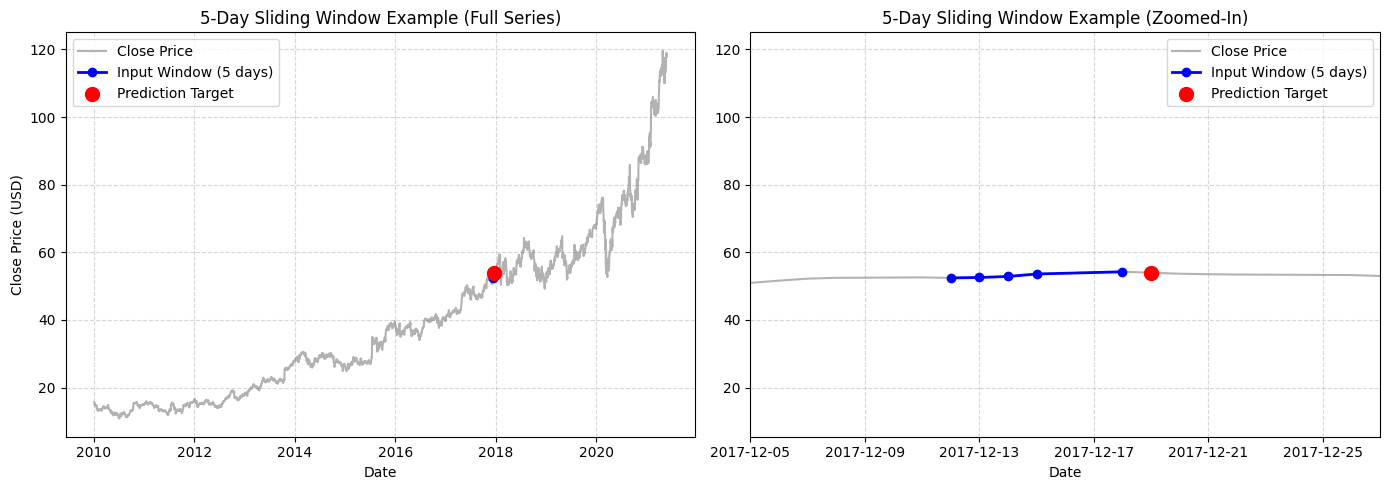

In [10]:
def plot_sliding_window_side_by_side(df, start_idx, window_size, title):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # --- Full series ---
    axes[0].plot(df["Date"], df["Close"], color="gray", alpha=0.6, label="Close Price")
    input_dates = df["Date"].iloc[start_idx:start_idx+window_size]
    input_prices = df["Close"].iloc[start_idx:start_idx+window_size]
    axes[0].plot(input_dates, input_prices, color="blue", linewidth=2, marker="o", label=f"Input Window ({window_size} days)")
    pred_date = df["Date"].iloc[start_idx+window_size]
    pred_price = df["Close"].iloc[start_idx+window_size]
    axes[0].scatter(pred_date, pred_price, color="red", s=100, zorder=5, label="Prediction Target")
    axes[0].set_title(f"{title} (Full Series)")
    axes[0].set_xlabel("Date")
    axes[0].set_ylabel("Close Price (USD)")
    axes[0].legend()
    axes[0].grid(True, linestyle="--", alpha=0.5)

    # --- Zoomed-in ---
    axes[1].plot(df["Date"], df["Close"], color="gray", alpha=0.6, label="Close Price")
    axes[1].plot(input_dates, input_prices, color="blue", linewidth=2, marker="o", label=f"Input Window ({window_size} days)")
    axes[1].scatter(pred_date, pred_price, color="red", s=100, zorder=5, label="Prediction Target")
    start = start_idx - 5 if start_idx - 5 > 0 else 0
    end = start_idx + window_size + 5
    axes[1].set_xlim(df["Date"].iloc[start], df["Date"].iloc[end])
    axes[1].set_title(f"{title} (Zoomed-In)")
    axes[1].set_xlabel("Date")
    axes[1].legend()
    axes[1].grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()

# Example for 5-day window
plot_sliding_window_side_by_side(df, start_idx=2000, window_size=5, title="5-Day Sliding Window Example")


## Step 5: Sequence Construction

Since LSTM models require sequential input, the dataset was transformed into overlapping sequences of five trading days (the chosen window length). Each sequence of features corresponds to the next day’s closing price as the prediction target. This approach ensures the model can capture short-term temporal dependencies while preventing any data leakage across training and test splits. The resulting training set contained 2,275 sequences, and the test set contained 566 sequences, each with 9 features.

In [11]:
# 5) Build sequences AFTER the split (no boundary bleed)
def make_sequences(X, y, dates, seq_len):
    """X_seq[i]=X[i-seq_len:i], y_seq[i]=y[i], date=dates[i]."""
    X_seq, y_seq, d_seq = [], [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i-seq_len:i, :])
        y_seq.append(y[i])
        d_seq.append(dates[i])
    return np.asarray(X_seq, dtype=np.float32), np.asarray(y_seq, dtype=np.float32), np.asarray(d_seq)

X_train, y_train_seq, train_label_dates = make_sequences(
    X_train_scaled, y_train, df_train["Date"].values, SEQ_LEN
)
X_test,  y_test_seq,  test_label_dates  = make_sequences(
    X_test_scaled,  y_test,  df_test["Date"].values,  SEQ_LEN
)

print("Sequence shapes:")
print("  X_train:", X_train.shape, "| y_train:", y_train_seq.shape)
print("  X_test :", X_test.shape,  "| y_test :", y_test_seq.shape)
print("  n_features:", X_train.shape[-1])


Sequence shapes:
  X_train: (2275, 5, 9) | y_train: (2275,)
  X_test : (566, 5, 9) | y_test : (566,)
  n_features: 9


## Step 6: Model Design and Training


The predictive model was implemented using a sequential LSTM architecture. Two stacked LSTM layers (128 and 64 units) were used to capture temporal dependencies, with dropout applied to reduce overfitting. A dense output layer produced the final one-step-ahead forecast. The model was compiled with the Adam optimizer and mean squared error (MSE) as the loss function. Training was performed for up to 100 epochs with a batch size of 32, using 20% of the training set for validation. To ensure stable performance, early stopping was applied to monitor validation loss and automatically restore the best weights. This setup allowed the model to learn sequential market dynamics while preventing overfitting.

In [12]:
from tensorflow.keras import backend as K, callbacks
K.clear_session()

SEQ_LEN = 5  # <-- 5-day window

model = tf.keras.Sequential([
    layers.Input(shape=(SEQ_LEN, X_train.shape[-1])),
    layers.LSTM(128, return_sequences=True),
    layers.Dropout(0.3),
    layers.LSTM(64),
    layers.Dense(1),
])
model.compile(optimizer="adam", loss="mse")

# explicit, fixed validation set (last 20% of training sequences)
n_total = len(X_train)
n_val   = int(0.20 * n_total)
X_tr, y_tr = X_train[:-n_val], y_train_seq[:-n_val]
X_val, y_val = X_train[-n_val:], y_train_seq[-n_val:]

ckpt = callbacks.ModelCheckpoint(
    "lstm5_best.keras",     # <-- distinct filename for 5-day
    monitor="val_loss",
    mode="min",
    save_best_only=True
)
es = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    shuffle=False,   # keep chronology
    callbacks=[ckpt, es],
    verbose=1
)

# (Optional) report best epoch
import numpy as np
print(f"Best epoch: {np.argmin(history.history['val_loss'])+1} | "
      f"best val_loss: {np.min(history.history['val_loss']):.6f}")

# Load


Epoch 1/100


2025-08-23 15:41:32.755450: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-08-23 15:41:32.755750: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0029 - val_loss: 0.0143
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0245 - val_loss: 0.0190
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0123 - val_loss: 0.0048
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067 - val_loss: 0.0034
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - val_loss: 0.0048
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.9463e-04 - val_loss: 0.0061
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.2246e-04 - val_loss: 0.0056
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.4376e-04 - val_loss: 0.0016
Epoch 9/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5408e-04 - val_loss: 0.0014
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.4101e-04 - val_loss: 0.0015
Epoch 11/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8686e-04 - val_loss: 0.0013
Epoch 12/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

## Step 7: Model Evaluation and Metrics

The LSTM model was evaluated using MAE, RMSE, and sMAPE on both normalized and USD-transformed values. Normalized metrics enable fair comparison across models, while USD values reflect practical forecasting accuracy. The 5-day model achieved MAE ≈ $11.07, RMSE ≈ $15.58, and sMAPE ≈ 14.10% in USD terms, showing that predictions deviated by roughly $11 on average from the actual closing price. These results indicate that while the model captured the general structure of GOOGL’s stock price movements, its shorter input horizon restricted precision and led to systematic underestimation during highly volatile periods.

In [13]:
# 7) Metrics — normalized + USD (define sMAPE here; inverse via TARGET scaler only)
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def smape(a, f):
    a = np.asarray(a).reshape(-1)
    f = np.asarray(f).reshape(-1)
    return 100 * np.mean(2 * np.abs(f - a) / (np.abs(a) + np.abs(f) + 1e-8))

y_pred_norm = model.predict(X_test, verbose=0).reshape(-1)

# Normalized
mae_norm  = mean_absolute_error(y_test_seq, y_pred_norm)
rmse_norm = np.sqrt(mean_squared_error(y_test_seq, y_pred_norm))
smape_norm = smape(y_test_seq, y_pred_norm)

# Align USD vectors to sequence labels
y_test_usd_vec = y_test_usd.reshape(-1)
y_test_usd_seq = y_test_usd_vec[SEQ_LEN:]

# Inverse via TARGET scaler only
y_pred_usd = scaler_y.inverse_transform(y_pred_norm.reshape(-1,1)).reshape(-1)

# USD
mae_usd  = mean_absolute_error(y_test_usd_seq, y_pred_usd)
rmse_usd = np.sqrt(mean_squared_error(y_test_usd_seq, y_pred_usd))
smape_usd = smape(y_test_usd_seq, y_pred_usd)

print("Normalized:")
print(f"  MAE={mae_norm:.6f}  RMSE={rmse_norm:.6f}  sMAPE={smape_norm:.4f}%")
print("USD:")
print(f"  MAE=${mae_usd:,.4f}  RMSE=${rmse_usd:,.4f}  sMAPE={smape_usd:.4f}%")


Normalized:
  MAE=0.207366  RMSE=0.291890  sMAPE=16.4663%
USD:
  MAE=$11.0655  RMSE=$15.5759  sMAPE=14.1046%


### Sanity Checks and Alignment

Final checks confirmed that the scaler correctly preserved values during inverse transformation with negligible error. The predicted and true values aligned perfectly with dates across the test period (2019–2021), ensuring consistency between labels and model outputs.

In [14]:
# 8) Sanity checks (round-trip scaler + date alignment)
roundtrip = scaler_y.inverse_transform(scaler_y.transform(y_test_usd_seq.reshape(-1,1))).reshape(-1)
avg_abs_diff = np.mean(np.abs(roundtrip - y_test_usd_seq))
print("Round-trip avg abs diff:", avg_abs_diff)   # ~1e-15–1e-12

print("Lengths | dates / y_true_usd / y_pred_usd:",
      len(test_label_dates), len(y_test_usd_seq), len(y_pred_usd))
print("First aligned:",
      pd.to_datetime(test_label_dates[SEQ_LEN-1]).date(),
      float(y_test_usd_seq[0]), float(y_pred_usd[0]))
print("Last aligned:",
      pd.to_datetime(test_label_dates[-1]).date(),
      float(y_test_usd_seq[-1]), float(y_pred_usd[-1]))


Round-trip avg abs diff: 5.3479011560742524e-15
Lengths | dates / y_true_usd / y_pred_usd: 566 566 566
First aligned: 2019-03-07 57.67100143432617 54.7271728515625
Last aligned: 2021-05-27 117.84249877929688 76.54371643066406


In [15]:
# Align to same length
min_len = min(len(test_label_dates), len(y_test_usd_seq), len(y_pred_usd))

# Build tidy results frame
out_df = pd.DataFrame({
    "Date": pd.to_datetime(test_label_dates[:min_len]),
    "Actual": y_test_usd_seq[:min_len],
    "Predicted": y_pred_usd[:min_len],
})
out_df["Residual"] = out_df["Actual"] - out_df["Predicted"]


## Actual vs Predicted Prices

The chart shows actual GOOGL next-day closing prices against the LSTM model’s predictions. While the model successfully follows the general upward trend and major movements, it consistently underpredicts the true prices, staying below the actual curve. The predicted line is also smoother, meaning the LSTM captures broad trends but struggles with short-term volatility and sharper fluctuations.

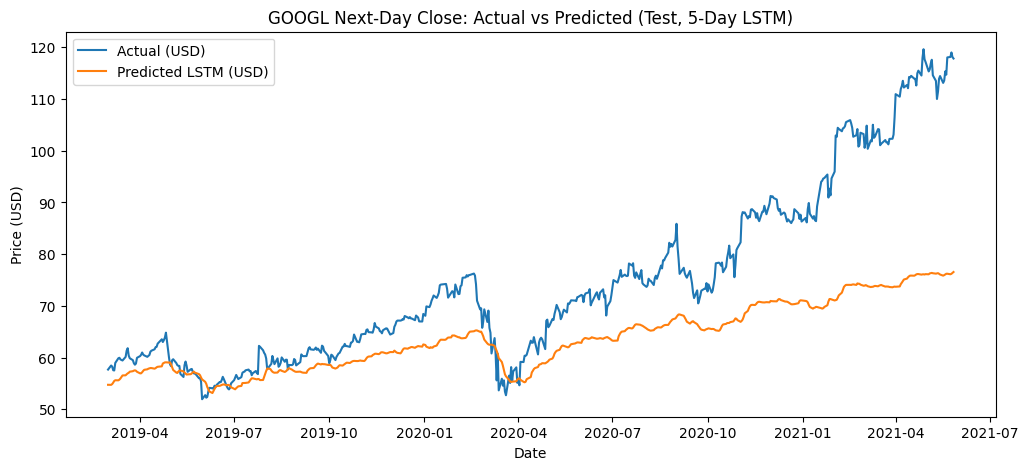

In [16]:
plt.figure(figsize=(12,5))
plt.plot(out_df["Date"], out_df["Actual"], label="Actual (USD)")
plt.plot(out_df["Date"], out_df["Predicted"], label="Predicted LSTM (USD)")
plt.title("GOOGL Next-Day Close: Actual vs Predicted (Test, 5-Day LSTM)")
plt.xlabel("Date"); 
plt.ylabel("Price (USD)");
plt.legend();
plt.show()

## Scatter Plot: Actual vs Predicted GOOGL Prices

The scatter plot compares actual GOOGL stock prices against LSTM predictions, with the red diagonal line indicating perfect prediction. While the model tracks general price movements, most points fall below the line, showing that the LSTM consistently underestimates higher stock values. This indicates the model captures short-term fluctuations but struggles to fully reflect sharp upward trends in the stock’s growth.

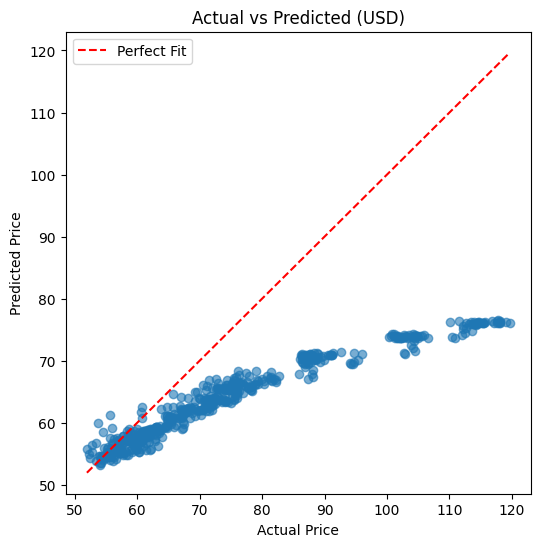

In [17]:
# 3) Scatter Plot (Actual vs Predicted)
plt.figure(figsize=(6,6))
plt.scatter(y_test_usd_seq, y_pred_usd, alpha=0.6)
plt.plot([y_test_usd_seq.min(), y_test_usd_seq.max()],
         [y_test_usd_seq.min(), y_test_usd_seq.max()],
         color="red", linestyle="--", label="Perfect Fit")
plt.title("Actual vs Predicted (USD)")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.legend()
plt.show()

## Residual Analysis

Residuals (actual – predicted) show that the model performed well initially, with small errors. However, after 2020, residuals grow larger and stay mostly positive, meaning the model increasingly underestimates prices. This confirms that the LSTM struggles to keep up with the strong upward trend in GOOGL stock during the later period.

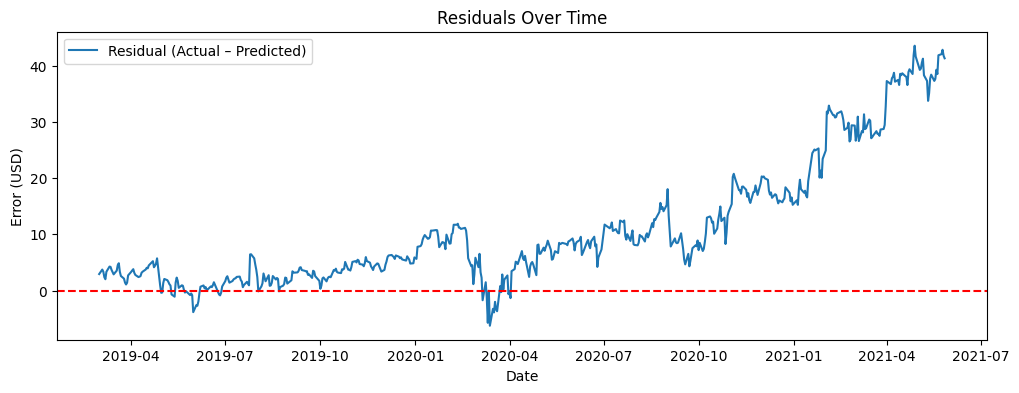

In [18]:
# Residuals Over Time
residuals = y_test_usd_seq - y_pred_usd

plt.figure(figsize=(12,4))
plt.plot(test_label_dates, residuals, label="Residual (Actual – Predicted)")
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Error (USD)")
plt.legend()
plt.show()


### Save test-set predictions (USD)

In [19]:
print(len(test_label_dates))
print(len(y_test_usd))
print(len(y_pred_usd))


566
571
566


In [20]:
min_len = min(len(test_label_dates), len(y_test_usd), len(y_pred_usd))

lstm_results = pd.DataFrame({
    "Date": test_label_dates[-min_len:],         # keep last 562 dates
    "Actual_Close_USD": y_test_usd.reshape(-1)[-min_len:],
    "Predicted_Close_USD": y_pred_usd.reshape(-1)[-min_len:]
})

out_path = "LSTM_test_predictions_USD.csv"
lstm_results.to_csv(out_path, index=False)
print(f"Saved {len(lstm_results)} rows to {out_path}")


Saved 566 rows to LSTM_test_predictions_USD.csv


In [21]:
print("Dates length:", len(test_label_dates))
print("Actual length:", len(y_test_usd))
print("Predicted length:", len(y_pred_usd))


Dates length: 566
Actual length: 571
Predicted length: 566


## Conclusion

The 5-day LSTM model, using engineered technical and calendar features, achieved MAE ≈ $11.07, RMSE ≈ $15.58, and sMAPE ≈ 14.10%. It captured overall price trends but systematically underestimated sharp rallies, especially after 2020. Compared to the benchmark 20-day setup, this shorter window offered reasonable short-term forecasts but lacked the contextual depth needed for volatile market phases.